# Import Libraries

In [128]:
import warnings
warnings.filterwarnings("ignore")
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from os import listdir
from os.path import isfile, join
import joypy
from joypy import joyplot
from matplotlib import cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.metrics import r2_score
from scipy.stats import pearsonr

# Define paths

In [118]:
data_path = os.path.dirname(os.getcwd()) + '/data'
figure_path = os.path.dirname(os.getcwd()) + '/figures'

In [119]:
molpatch_af_path = data_path + '/validation/molpatch/alphafold/'
molpatch_pdb_path = data_path + '/validation/molpatch/targets/'
patchprot = pd.read_csv(data_path + '/validation/molpatch/patchprot/results.csv')

files_molpatch_af = [f for f in listdir(molpatch_af_path) if isfile(join(molpatch_af_path, f))]
files_molpatch_targets = [f for f in listdir(molpatch_pdb_path) if isfile(join(molpatch_pdb_path, f))]

# Import and preprocess MolPatch calculations

In [120]:
LHP_dict = {'id':[], 'LHP':[]}
for file in files_molpatch_af[0:]:
    id = ''.join(file.split('.')[:-1])
    file = pd.read_csv(molpatch_af_path + file, sep=',', engine='python')
    LHP = file['patch_size'].max()
    LHP_dict['id'].append(id)
    LHP_dict['LHP'].append(LHP)
                   
    alphafold = pd.DataFrame(LHP_dict)

In [121]:
LHP_dict = {'id':[], 'LHP':[]}
for file in files_molpatch_targets[0:]:
    id = ''.join(file.split('.')[:-1])
    file = pd.read_csv(molpatch_pdb_path + file, sep=',', engine='python')
    LHP = file['patch_size'].max()
    LHP_dict['id'].append(id)
    LHP_dict['LHP'].append(LHP)
                   
    pdbs = pd.DataFrame(LHP_dict)

# Merge files

In [122]:
pdbs['id'] = pdbs["id"].str[:-2]
pdbs['LHP_pdb'] = pdbs['LHP']
pdbs= pdbs[['id', 'LHP_pdb']]

alphafold['LHP_af'] = alphafold['LHP']
alphafold= alphafold[['id', 'LHP_af']]

patchprot['LHP_pp'] = patchprot['LHP_predicted']
patchprot['id'] = patchprot['ID']
patchprot = patchprot[['id', 'LHP_pp']]

patches = pd.merge(alphafold, patchprot, on='id', how='inner')
patches = pd.merge(patches, pdbs, on='id', how='inner')

In [157]:
target_classes = pd.read_csv(data_path + '/validation/casp14/target_classes.csv')
patches_classes = pd.merge(target_classes, patches, left_on='Target', right_on='id', how='inner').drop(columns=['id'])
fm_patches = patches_classes[patches_classes['Classification'] == 'FM']
multi_dom_patches = patches_classes[patches_classes['Classification'] == 'MultiDom']
tbm_easy_patches = patches_classes[patches_classes['Classification'] == 'TBM-easy']
tbm_hard_patches = patches_classes[patches_classes['Classification'] == 'TBM-hard']
fm_tbm_patches = patches_classes[patches_classes['Classification'] == 'FM/TBM']

In [158]:
def patch_correlation(df):
    print('correlation between pdb and PatchProt')
    print(pearsonr(df['LHP_pp'], df['LHP_pdb']))
    print('correlation between alphafold and pdb')
    print(pearsonr(df['LHP_af'], df['LHP_pdb']))

In [159]:
patch_correlation(patches_classes)

correlation between pdb and PatchProt
PearsonRResult(statistic=0.6872698067598983, pvalue=2.5475430460003734e-08)
correlation between alphafold and pdb
PearsonRResult(statistic=0.9016563993594211, pvalue=1.81410272205322e-19)


# Compare

In [160]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

def plot_patch_comparisons(patches, figure_file):
    pdb = np.array(patches['LHP_pdb'])
    patchprot = np.array(patches['LHP_pp'])
    alphafold = np.array(patches['LHP_af'])

    r2_pp = r2_score(pdb, patchprot)
    r2_af = r2_score(pdb, alphafold)

    fig, axs = plt.subplots(1, 2, figsize=(20, 6))

    axs[0].scatter(pdb, patchprot, color='blue', alpha=0.4)
    axs[0].plot(pdb, pdb, color='brown', linestyle='--', alpha=0.4)  
    axs[0].set_xlabel('LHP ($Å^2$) MolPatch (targets)')
    axs[0].set_ylabel('LHP ($Å^2$) PatchProt (predictions)')
    axs[0].set_title(f'PatchProt vs MolPatch (R2={r2_pp:.2f})')
    axs[0].grid(True)

    axs[1].scatter(pdb, alphafold, color='green', alpha=0.4)
    axs[1].plot(pdb, pdb, color='brown', linestyle='--', alpha=0.4)  
    axs[1].set_xlabel('LHP ($Å^2$) MolPatch (targets)')
    axs[1].set_ylabel('LHP ($Å^2$) MolPatch (AlphaFold)')
    axs[1].set_title(f'AlphaFold vs MolPatch (R2={r2_af:.2f})')
    axs[1].grid(True)

    fig.savefig(figure_file, dpi=600, bbox_inches='tight')
    plt.show()

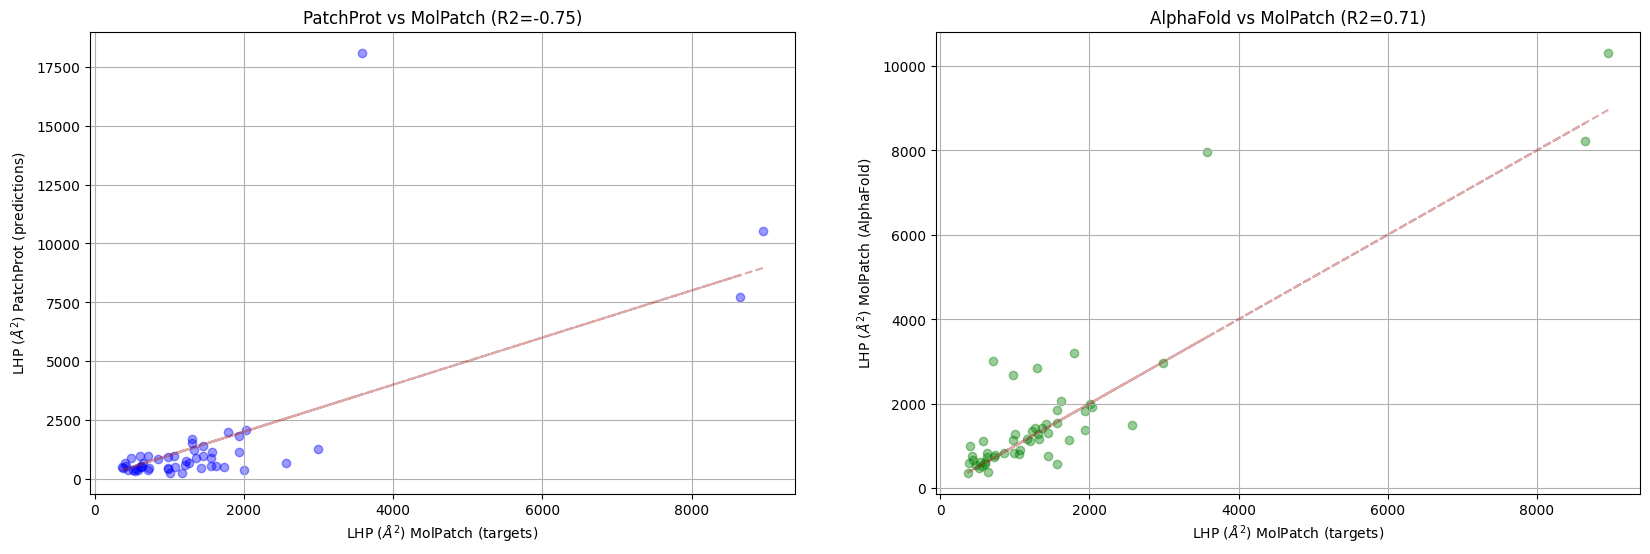

In [163]:
# patches_classes
plot_patch_comparisons(patches_classes, figure_path + '/casp14.png')

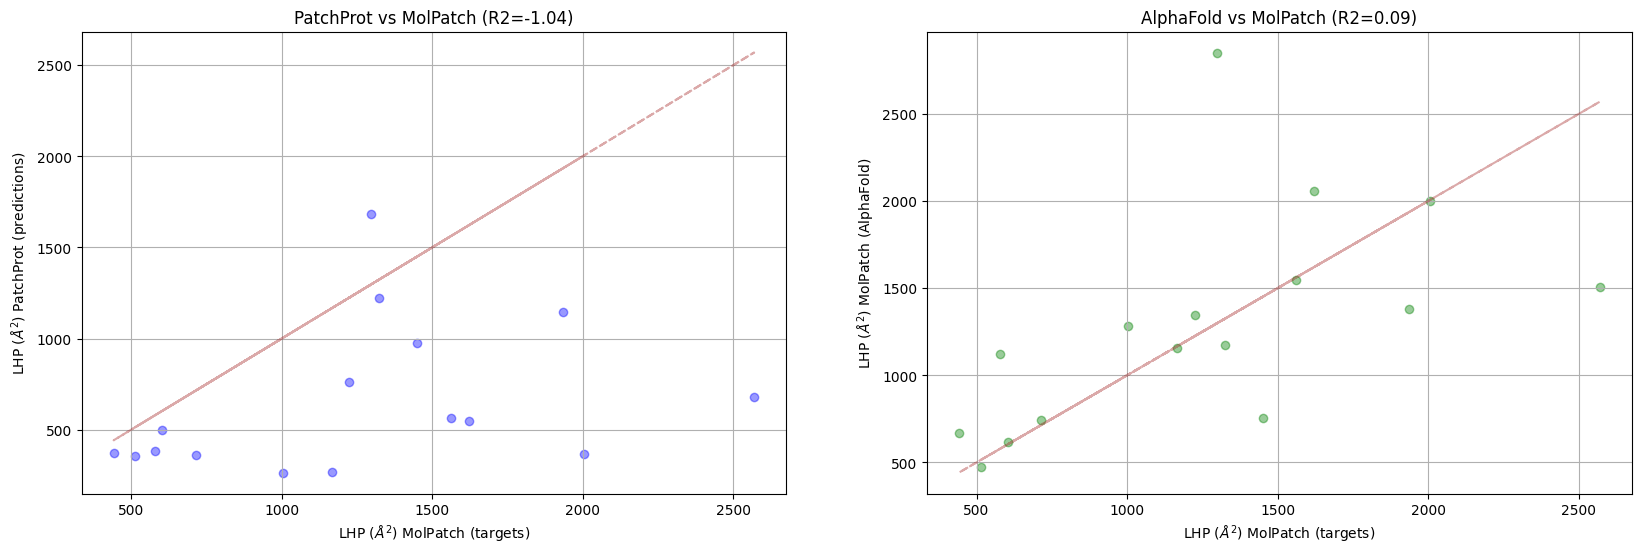

In [152]:
#FM patches
plot_patch_comparisons(fm_patches, figure_path + '/fm_casp14.png')

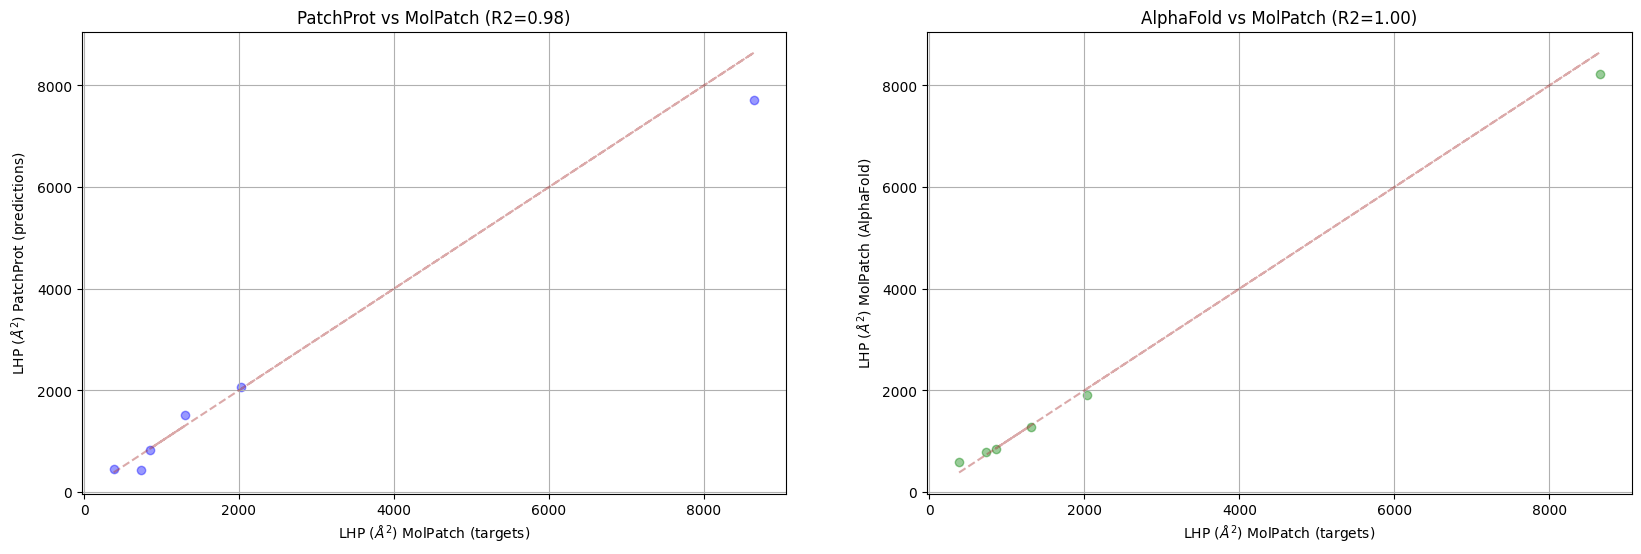

In [153]:
# multi_dom_patches
plot_patch_comparisons(multi_dom_patches, figure_path + '/multi_dom_casp14.png')

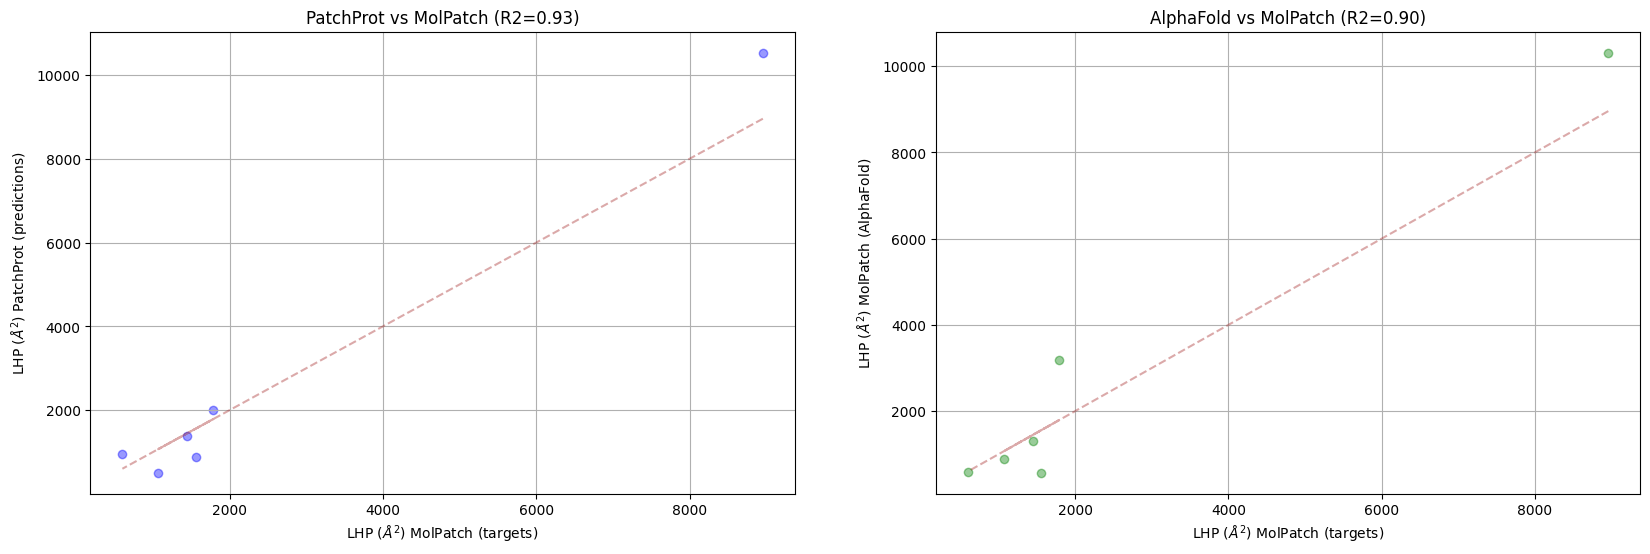

In [154]:
# tbm_easy_patches
plot_patch_comparisons(tbm_easy_patches, figure_path + '/tbm_easy_casp14.png')

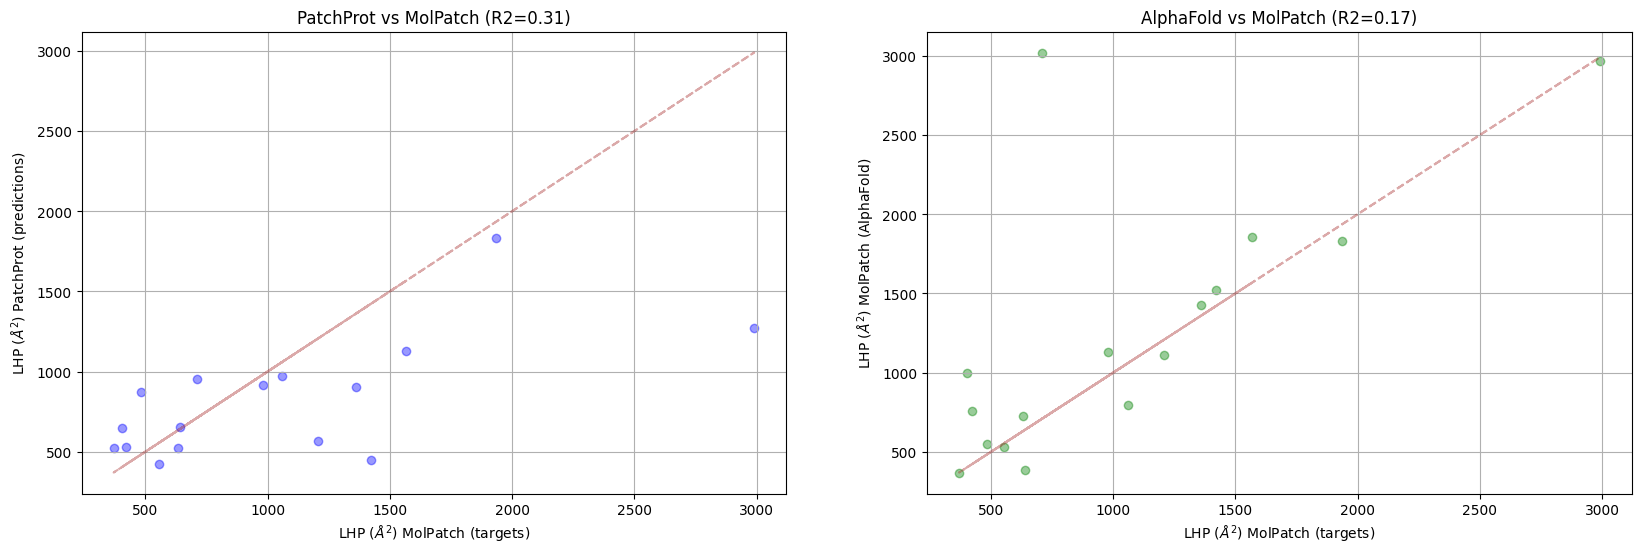

In [155]:
# tbm_hard_patches
plot_patch_comparisons(tbm_hard_patches, figure_path + '/tbm_hard_casp14.png')

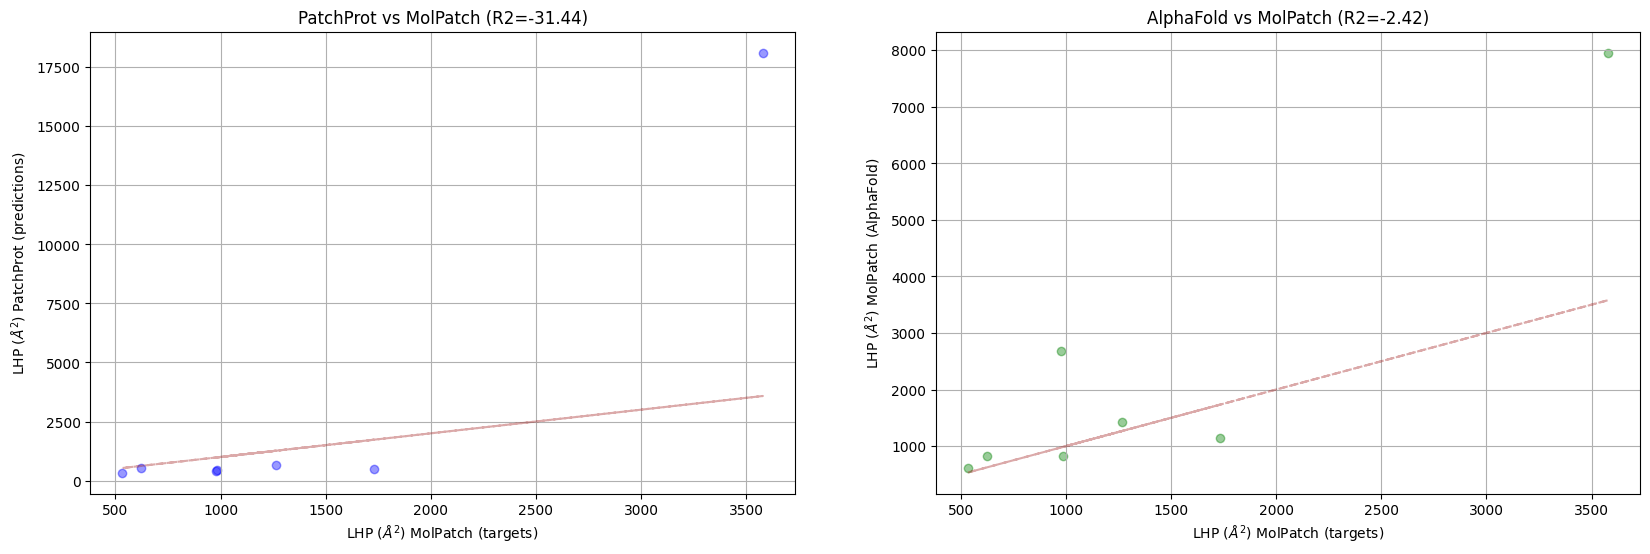

In [161]:
# fm_tbm_patches
plot_patch_comparisons(fm_tbm_patches, figure_path + '/fm_tbm_casp14.png')